(GLM-robust)=
# GLM: Robust Linear Regression

:::{post} August, 2013
:tags: regression, linear model, robust
:category: beginner
:author: Thomas Wiecki
:::

# GLM: Robust Linear Regression

This tutorial first appeard as a post in small series on Bayesian GLMs on:

  1. [The Inference Button: Bayesian GLMs made easy with PyMC3](https://twiecki.io/blog/2013/08/12/bayesian-glms-1/)
  2. [This world is far from Normal(ly distributed): Robust Regression in PyMC3](https://twiecki.io/blog/2013/08/27/bayesian-glms-2/)
  3. [The Best Of Both Worlds: Hierarchical Linear Regression in PyMC3](https://twiecki.io/blog/2014/03/17/bayesian-glms-3/)
  
In this blog post I will write about:

 - How a few outliers can largely affect the fit of linear regression models.
 - How replacing the normal likelihood with Student T distribution produces robust regression.
 - How this can easily be done with the `Bambi` library by passing a `family` object or passing the family name as an argument.
 
This is the second part of a series on Bayesian GLMs (click [here for part I about linear regression](http://twiecki.github.io/blog/2013/08/12/bayesian-glms-1/)). In this prior post I described how minimizing the squared distance of the regression line is the same as maximizing the likelihood of a Normal distribution with the mean coming from the regression line. This latter probabilistic expression allows us to easily formulate a Bayesian linear regression model.

This worked splendidly on simulated data. The problem with simulated data though is that it's, well, simulated. In the real world things tend to get more messy and assumptions like normality are easily violated by a few outliers. 

Lets see what happens if we add some outliers to our simulated data from the last post.

First, let's import our modules.

In [1]:
%matplotlib inline

import aesara
import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm

print(f"Running on pymc3 v{pm.__version__}")

Running on pymc3 v4.2.2


In [2]:
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

Create some toy data but also add some outliers.

In [3]:
size = 100
true_intercept = 1
true_slope = 2

x = np.linspace(0, 1, size)
# y = a + b*x
true_regression_line = true_intercept + true_slope * x
# add noise
y = true_regression_line + rng.normal(scale=0.5, size=size)

# Add outliers
x_out = np.append(x, [0.1, 0.15, 0.2])
y_out = np.append(y, [8, 6, 9])

data = pd.DataFrame(dict(x=x_out, y=y_out))

In [4]:
data.head()

,x,y
0,0.000000,0.888679
1,0.010101,1.683031
2,0.020202,0.754919
3,0.030303,1.394731
4,0.040404,1.653499


Plot the data together with the true regression line (the three points in the upper left corner are the outliers we added).

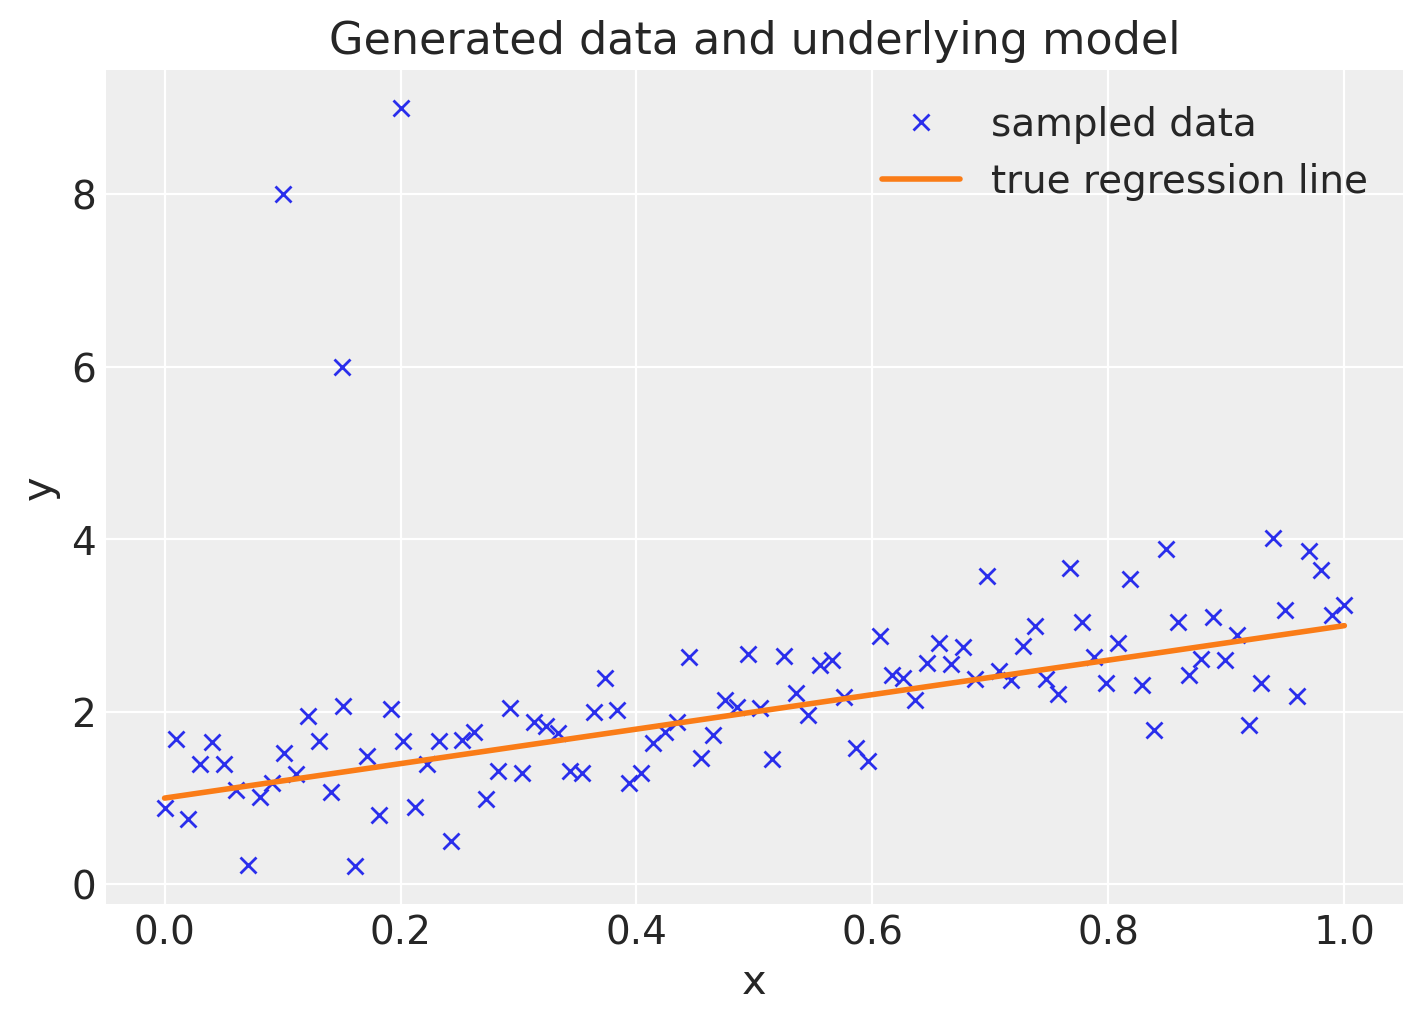

In [5]:
fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(111, xlabel="x", ylabel="y", title="Generated data and underlying model")
ax.plot(x_out, y_out, "x", label="sampled data")
ax.plot(x, true_regression_line, label="true regression line", lw=2.0)
plt.legend(loc=0);

## Robust Regression


Lets see what happens if we estimate our Bayesian linear regression model using the `bambi`. This function takes a [`formulae`](https://bambinos.github.io/formulae/api_reference.html) string to describe the linear model and adds a Normal likelihood for Intercept and Slope by default.

In [6]:
model = bmb.Model("y ~ x", data)
trace = model.fit(draws=2000, cores=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Intercept, x, y_sigma]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 13 seconds.


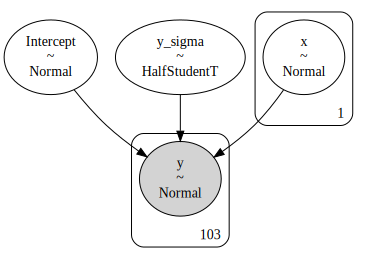

In [7]:
model.graph()

In [8]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,1.525,0.238,1.087,1.972,0.003,0.002,5681.0,2881.0,1.0
x,1.466,0.406,0.686,2.212,0.005,0.004,5745.0,3229.0,1.0
y_sigma,1.196,0.084,1.047,1.358,0.001,0.001,5205.0,3022.0,1.0


To evaluate the fit, the code below calculates the posterior predictive regression lines by taking regression parameters from the posterior distribution and plots a regression line for every 10th of them.

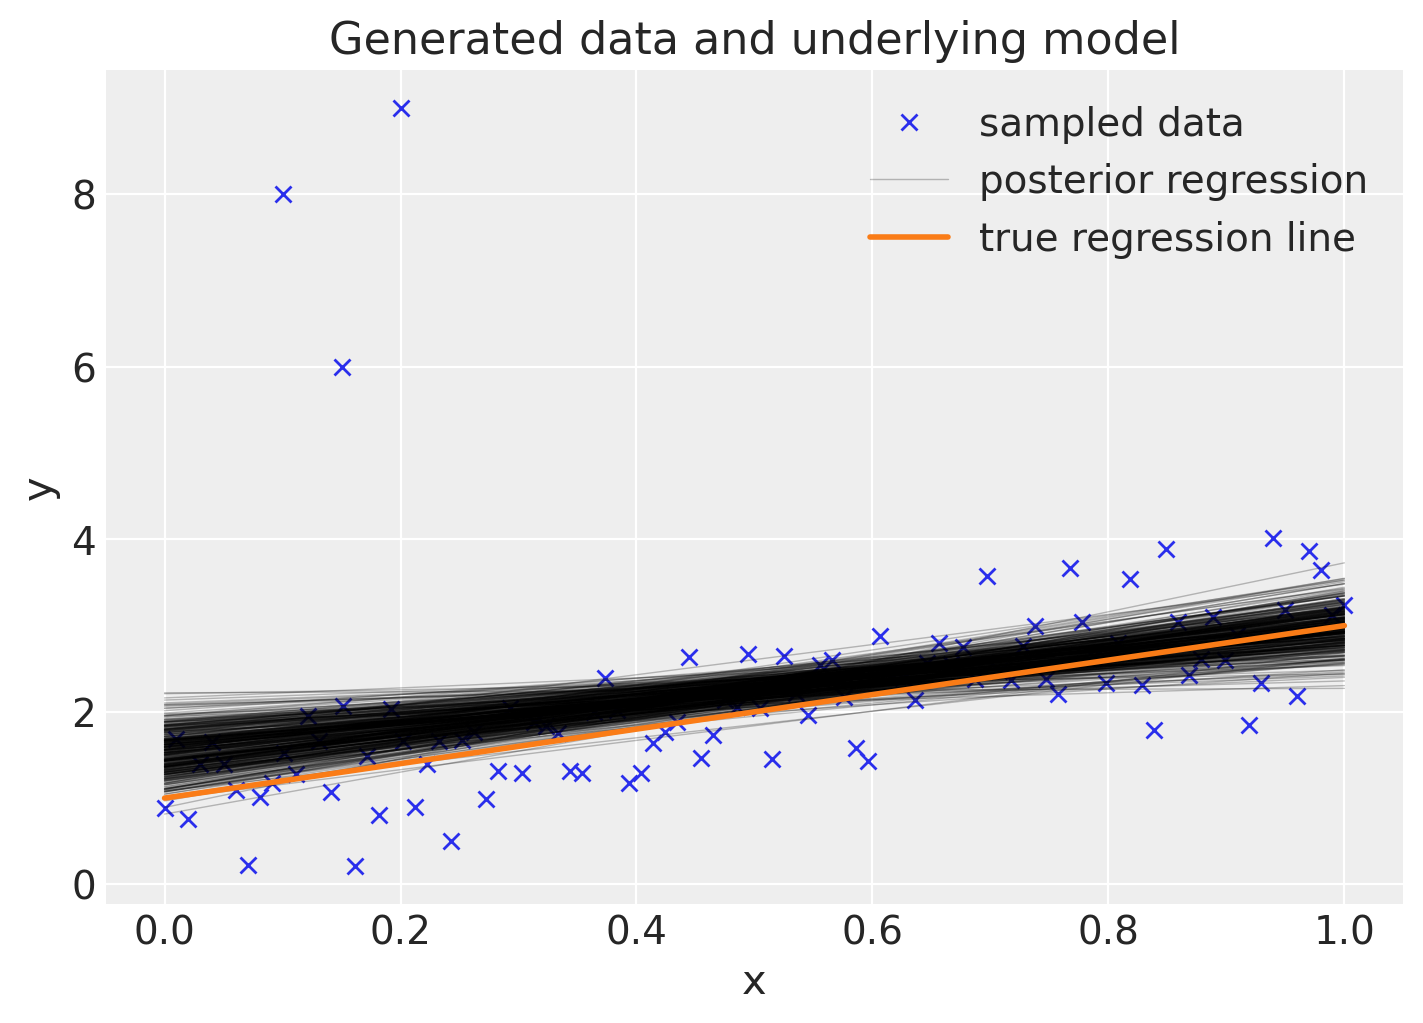

In [9]:
fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(111, xlabel="x", ylabel="y", title="Generated data and underlying model")
ax.plot(x_out, y_out, "x", label="sampled data")

# calculate posterior regression lines (for every 10th point from posterior)
for chain in range(2):
    for i in range(0, 2000, 10):
        regression_line = (
            trace.posterior.Intercept[chain, i].values + trace.posterior.x[chain, i].values * x
        )
        ax.plot(x, regression_line, lw=0.5, alpha=0.25, color="black", label="posterior regression")

ax.plot(x, true_regression_line, label="true regression line", lw=2.0)

# remove duplicate legend labels for posterior regression lines
handles, labels = plt.gca().get_legend_handles_labels()
newLabels, newHandles = [], []
for handle, label in zip(handles, labels):
    if label not in newLabels:
        newLabels.append(label)
        newHandles.append(handle)
_ = ax.legend(newHandles, newLabels, loc=0)

As you can see, the fit is quite skewed and we have a fair amount of uncertainty in our estimate as indicated by the wide range of different posterior predictive regression lines. Why is this? The reason is that the normal distribution does not have a lot of mass in the tails and consequently, an outlier will affect the fit strongly.

A Frequentist would estimate a [Robust Regression](http://en.wikipedia.org/wiki/Robust_regression) and use a non-quadratic distance measure to evaluate the fit.

But what's a Bayesian to do? Since the problem is the light tails of the Normal distribution we can instead assume that our data is not normally distributed but instead distributed according to the [Student T distribution](http://en.wikipedia.org/wiki/Student%27s_t-distribution) which has heavier tails as shown next (I read about this trick in ["The Kruschke"](https://www.elsevier.com/books/doing-bayesian-data-analysis/kruschke/978-0-12-405888-0), aka the puppy-book; but I think [Gelman](http://www.stat.columbia.edu/~gelman/book/) was the first to formulate this).

Lets look at those two distributions to get a feel for them.

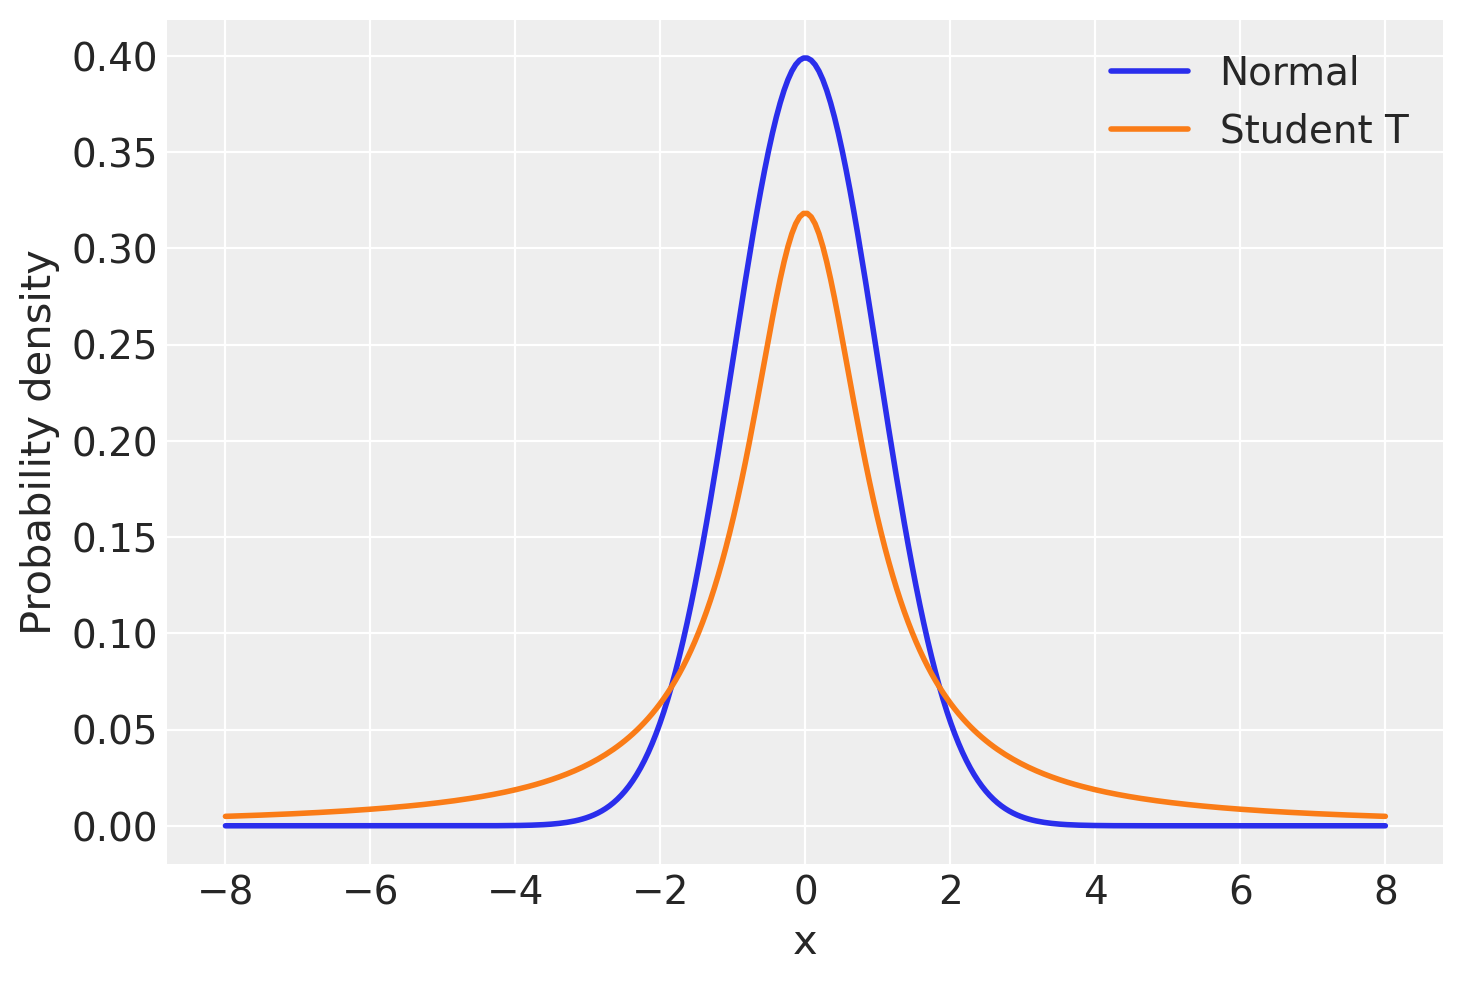

In [10]:
normal_dist = pm.Normal.dist(mu=0, sigma=1)
t_dist = pm.StudentT.dist(mu=0, lam=1, nu=1)
x_eval = np.linspace(-8, 8, 300)
plt.plot(x_eval, aesara.tensor.exp(pm.logp(normal_dist, x_eval)).eval(), label="Normal", lw=2.0)
plt.plot(x_eval, aesara.tensor.exp(pm.logp(t_dist, x_eval)).eval(), label="Student T", lw=2.0)
plt.xlabel("x")
plt.ylabel("Probability density")
plt.legend();

As you can see, the probability of values far away from the mean (0 in this case) are much more likely under the `T` distribution than under the Normal distribution.

To define the usage of a T distribution in `Bambi` we can pass the distribution name to the `family` argument  -- `t` -- that specifies that our data is Student T-distributed. Note that this is the same syntax as `R` and `statsmodels` use.

In [11]:
model_robust = bmb.Model("y ~ x", data, family="t")
model_robust.set_priors({"nu": bmb.Prior("Gamma", alpha=3, beta=1)})
trace_robust = model_robust.fit(draws=2000, cores=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Intercept, x, y_sigma, y_nu]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 14 seconds.


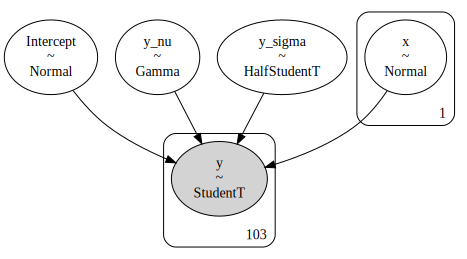

In [12]:
model_robust.graph()

In [13]:
az.summary(trace_robust)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,1.057,0.099,0.868,1.233,0.001,0.001,5042.0,2969.0,1.0
x,2.085,0.177,1.762,2.410,0.002,0.002,5266.0,3101.0,1.0
y_sigma,0.395,0.048,0.308,0.488,0.001,0.001,2714.0,3385.0,1.0
y_nu,2.242,0.518,1.319,3.161,0.009,0.007,3012.0,3098.0,1.0


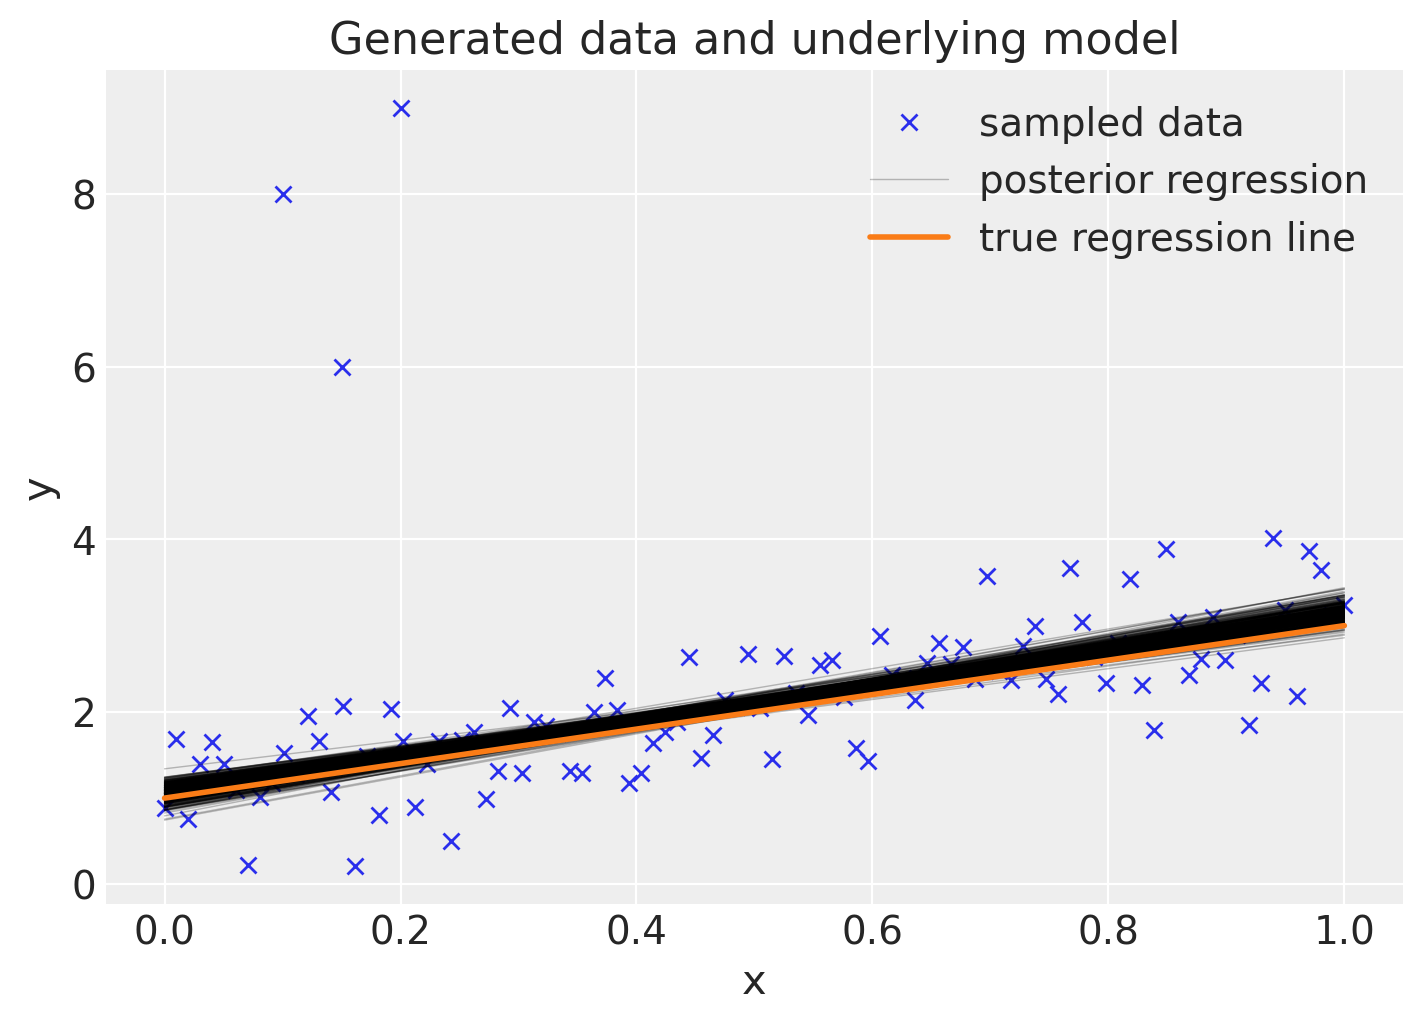

In [14]:
fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(111, xlabel="x", ylabel="y", title="Generated data and underlying model")
ax.plot(x_out, y_out, "x", label="sampled data")

# calculate posterior regression lines (for every 10th point from posterior)
for chain in range(2):
    for i in range(0, 2000, 10):
        regression_line = (
            trace_robust.posterior.Intercept[chain, i].values
            + trace_robust.posterior.x[chain, i].values * x
        )
        ax.plot(x, regression_line, lw=0.5, alpha=0.25, color="black", label="posterior regression")

ax.plot(x, true_regression_line, label="true regression line", lw=2.0)

# remove duplicate legend labels for posterior regression lines
handles, labels = plt.gca().get_legend_handles_labels()
newLabels, newHandles = [], []
for handle, label in zip(handles, labels):
    if label not in newLabels:
        newLabels.append(label)
        newHandles.append(handle)
_ = ax.legend(newHandles, newLabels, loc=0)

There, much better! The outliers are barely influencing our estimation at all because our likelihood function assumes that outliers are much more probable than under the Normal distribution.

## Summary

- `Bambi` allows you to pass in a `family` argument that contains information about the likelihood.
 - By changing the likelihood from a Normal distribution to a Student-T distribution -- which has more mass in the tails -- we can perform *Robust Regression*.

The next post will be about logistic regression in PyMC3 and what the posterior and oatmeal have in common.

*Extensions*: 

 - The Student-T distribution has, besides the mean and variance, a third parameter called *degrees of freedom* that describes how much mass should be put into the tails. Here it is set to 1 which gives maximum mass to the tails (setting this to infinity results in a Normal distribution!). One could easily place a prior on this rather than fixing it which I leave as an exercise for the reader ;).
 - T distributions can be used as priors as well. I will show this in a future post on hierarchical GLMs.
 - How do we test if our data is normal or violates that assumption in an important way? Check out this [great blog post](http://allendowney.blogspot.com/2013/08/are-my-data-normal.html) by Allen Downey.

## Authors

* Authored by Thomas Wiecki in August, 2013
* Updated by Igor Kuvychko in October, 2022

In [15]:
%load_ext watermark
%watermark -n -u -v -iv -w -p xarray

Last updated: Thu Oct 20 2022

Python implementation: CPython
Python version       : 3.10.5
IPython version      : 8.4.0

xarray: 2022.3.0

pymc      : 4.2.2
matplotlib: 3.5.2
aesara    : 2.8.7
pandas    : 1.4.3
arviz     : 0.12.1
numpy     : 1.21.6
bambi     : 0.9.1

Watermark: 2.3.1

